# Getting results from Data

In [1]:
import sqlite3
from db_functions import *
import main
from preprocess import *
from query_store import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

---
## Loading the DB

In [2]:
# Create test relational database
con = sqlite3.connect("test.db")
c = con.cursor()

---
# Only run this section if resetting the DB

In [4]:
# Foreign keys are off by default and must be set to On
c.execute("""PRAGMA foreign_keys = On""")

# For testing purposes, delete child tables then parent tables
c.execute("""DROP TABLE IF EXISTS game_event""")
c.execute("""DROP TABLE IF EXISTS game_round""")
c.execute("""DROP TABLE IF EXISTS player_weapon""")
c.execute("""DROP TABLE IF EXISTS player_class""")
c.execute("""DROP TABLE IF EXISTS game_player""")
c.execute("""DROP TABLE IF EXISTS game_table""")

c.execute("""DROP TABLE IF EXISTS class_kill""")

# Table generation
c.execute("""CREATE TABLE IF NOT EXISTS game_table (
                    game_ID INT NOT NULL,
                    map TEXT,
                    time INT,
                    blu_firstcaps INT,
                    red_firstcaps INT,
                    blu_score INT,
                    red_score INT,
                    winner TEXT,
                    PRIMARY KEY (game_ID)
          )""")

c.execute("""CREATE TABLE IF NOT EXISTS game_round (
                    game_ID INT NOT NULL,
                    round_num INT NOT NULL,
                    blu_dmg INT,
                    blu_kills INT,
                    blu_ubers INT,
                    red_dmg INT,
                    red_kills INT,
                    red_ubers INT,          
                    winner TEXT,
                    firstcap TEXT,
                    length INT,
                    PRIMARY KEY (game_ID, round_num),
                    FOREIGN KEY (game_ID) REFERENCES game_table(game_ID)
          )""")

c.execute("""CREATE TABLE IF NOT EXISTS game_event (
                    game_ID INT NOT NULL,
                    round_num INT NOT NULL,
                    event_num INT NOT NULL,
                    team TEXT,
                    event_name TEXT,
                    Time INT,
                    PRIMARY KEY (game_ID, round_num, event_num),
                    FOREIGN KEY (game_ID, round_num) REFERENCES game_round(game_ID, round_num)
          )""")

c.execute("""CREATE TABLE IF NOT EXISTS game_player (
                    game_ID INT NOT NULL,
                    player_ID TEXT NOT NULL,
                    team TEXT,
                    kills INT,
                    deaths INT,
                    assists INT,
                    dmg INT,
                    medkits INT,
                    ubers INT,
                    hr INT,
                    healing INT,
                    PRIMARY KEY (game_ID, player_ID),
                    FOREIGN KEY (game_ID) REFERENCES game_table(game_ID)
          )""")

c.execute("""CREATE TABLE IF NOT EXISTS player_class (
                    game_ID INT NOT NULL,
                    player_ID TEXT NOT NULL,
                    class TEXT NOT NULL,
                    time INT, 
                    kills INT,
                    deaths INT,
                    assists INT,
                    PRIMARY KEY (game_ID, player_ID, class),
                    FOREIGN KEY (game_ID, player_ID) REFERENCES game_player(game_ID, player_ID)
          )""")

c.execute("""CREATE TABLE IF NOT EXISTS player_weapon (
                    game_ID INT NOT NULL,
                    player_ID TEXT NOT NULL,
                    weapon_name TEXT NOT NULL,
                    kills INT,
                    dmg INT,
                    avg_dmg REAL,
                    shots INT,
                    hits INT,
                    PRIMARY KEY (game_ID, player_ID, weapon_name),
                    FOREIGN KEY (game_ID, player_ID) REFERENCES game_player(game_ID, player_ID)
          )""")

c.execute("""CREATE TABLE IF NOT EXISTS class_kill (
                    class TEXT,
                    class_killed TEXT,
                    kills INT
          )""")

c.execute("""CREATE TABLE IF NOT EXISTS class_deaths (
                    class TEXT,
                    deaths INT
          )""")

# Commit changes to the db
con.commit()

In [101]:
query_store('log_outputs.json', 'test.db', 40)

---
# Getting Results

<Axes: title={'center': 'Win Rate Based On Team'}, xlabel='winner'>

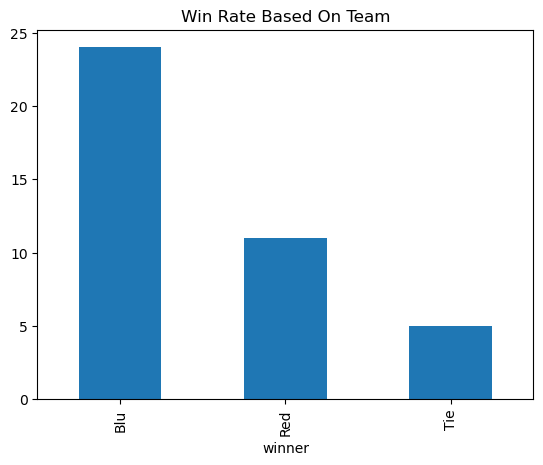

In [3]:
c.execute("""SELECT * FROM game_table""")

results = c.fetchall()

team_df = pd.DataFrame(results, columns=[desc[0] for desc in c.description]) 
team_df['winner'].value_counts().plot(kind='bar', title='Win Rate Based On Team')

<Axes: title={'center': 'Is The Team That Captures First More The Winner?'}, xlabel='Is Higher First Cap Winner'>

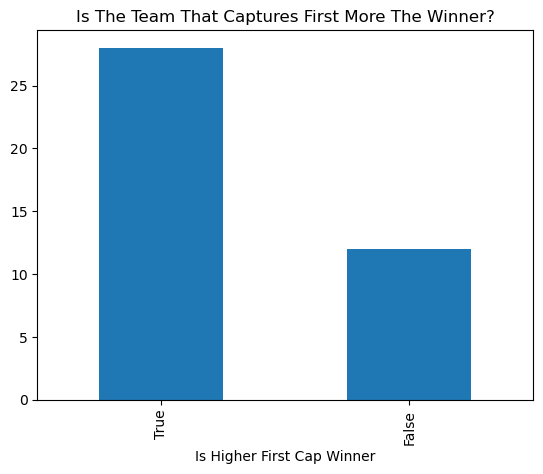

In [4]:
c.execute("""SELECT * FROM game_table""")

results = c.fetchall()

game_table_df = pd.DataFrame(results, columns=[desc[0] for desc in c.description]) 

game_table_df["Higher First Cap"] = np.where(
    game_table_df['red_firstcaps'] > game_table_df['blu_firstcaps'],
    'Red',
    'Blu'
)
game_table_df["Is Higher First Cap Winner"] = np.where(
    game_table_df['Higher First Cap'] == game_table_df['winner'],
    True,
    False
)

game_table_df['Is Higher First Cap Winner'].value_counts().plot(kind='bar', title='Is The Team That Captures First More The Winner?')

Text(0, 0.5, 'Number of Games')

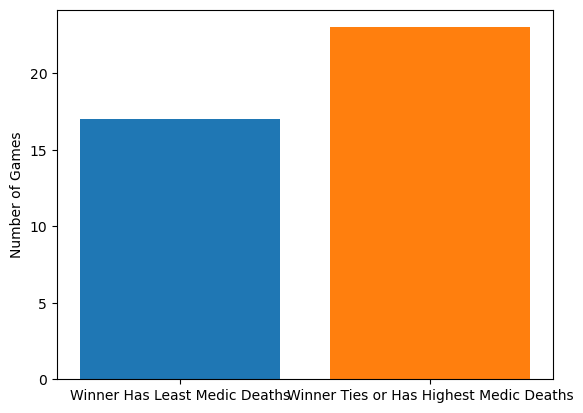

In [5]:
c.execute("""SELECT game_event.game_ID, team, event_name, game_table.winner
          FROM game_event 
          INNER JOIN game_table 
          ON game_table.game_ID""")

results = c.fetchall()

medic_death_df = pd.DataFrame(results, columns=[desc[0] for desc in c.description]) 
num_games = medic_death_df['game_ID'].nunique()

medic_death_df = medic_death_df[medic_death_df['event_name'] == 'medic_death']

team_counts = medic_death_df.groupby(['game_ID', 'team']).size().reset_index(name='team_count')

result = pd.merge(medic_death_df, team_counts, on=['game_ID', 'team'])

# Show if the one with the most med deaths was the one that lost
min_count = result.groupby('game_ID')['team_count'].min()
result_with_min = result.merge(min_count, on='game_ID', suffixes=('', '_min'))
result_with_min['winner_has_lowest_med_deaths'] = ((result_with_min['team'] == result_with_min['winner']) & 
                                                   (result_with_min['team_count'] == result_with_min['team_count_min'])
                                                   )
winner_has_lowest_med_deaths = result_with_min.groupby('game_ID')['winner_has_lowest_med_deaths'].max().sum()

plt.bar(['Winner Has Least Medic Deaths'], [winner_has_lowest_med_deaths])
plt.bar(['Winner Ties or Has Highest Medic Deaths'], [num_games - winner_has_lowest_med_deaths])
plt.ylabel('Number of Games')

Text(0, 0.5, 'Number of Games')

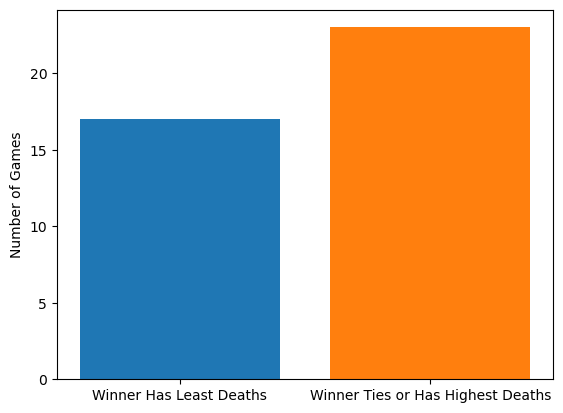

In [58]:
c.execute("""SELECT game_player.game_ID, player_ID, team, kills, deaths, winner 
          FROM game_player
          INNER JOIN game_table
          ON game_table.game_ID""")

results = c.fetchall()

player_df = pd.DataFrame(results, columns=[desc[0] for desc in c.description]) 
num_games = player_df['game_ID'].nunique()
player_df = player_df.drop_duplicates(subset=['game_ID', 'team', 'player_ID', 'winner'])


sum_deaths = player_df.groupby(['game_ID', 'team'])['deaths'].sum().reset_index()
sum_kills = player_df.groupby(['game_ID', 'team'])['kills'].sum().reset_index()


result = pd.merge(player_df, sum_deaths, on=['game_ID', 'team'], suffixes=['_player', '_team'])

result = pd.merge(result, sum_kills, on=['game_ID', 'team'], suffixes=['_player', '_team'])


min_count = result.groupby('game_ID')['deaths_team'].min()
result_with_min = result.merge(min_count, on='game_ID', suffixes=('', '_min'))

result_with_min['winner_has_least_deaths'] = ((result_with_min['team'] == result_with_min['winner']) & 
                                                   (result_with_min['deaths_team'] == result_with_min['deaths_team_min'])
                                                   )
winner_has_least_deaths = result_with_min.groupby('game_ID')['winner_has_least_deaths'].max().sum()

plt.bar(['Winner Has Least Deaths'], [winner_has_least_deaths])
plt.bar(['Winner Ties or Has Highest Deaths'], [num_games - winner_has_least_deaths])
plt.ylabel('Number of Games')



Text(0, 0.5, 'Number of Games')

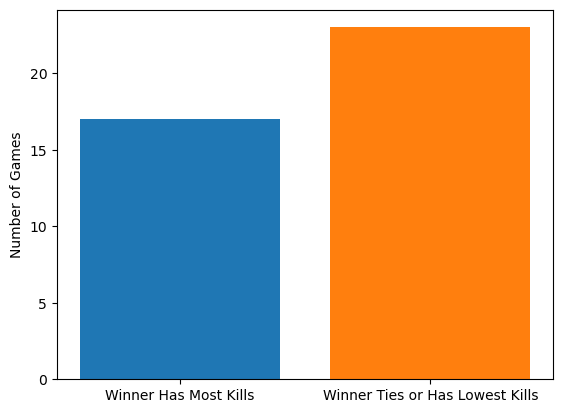

In [59]:
max_count = result.groupby('game_ID')['kills_team'].max()
result_with_max = result.merge(max_count, on='game_ID', suffixes=('', '_max'))

result_with_max['winner_has_most_kills'] = ((result_with_max['team'] == result_with_max['winner']) & 
                                                   (result_with_max['kills_team'] == result_with_max['kills_team_max'])
                                                   )
winner_has_most_kills = result_with_max.groupby('game_ID')['winner_has_most_kills'].max().sum()

plt.bar(['Winner Has Most Kills'], [winner_has_most_kills])
plt.bar(['Winner Ties or Has Lowest Kills'], [num_games - winner_has_most_kills])
plt.ylabel('Number of Games')